In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
from datetime import datetime
pd.set_option('display.max_colwidth', None)

In [3]:
releases_raw = pd.read_csv('../data/csv/releases.csv')

imports = pd.read_csv('../data/csv/imports.csv')
import_diffs = pd.read_csv('../data/csv/import_diffs.csv')
repo_imports = pd.read_csv('../data/csv/repo_imports.csv')
repo_import_diffs = pd.read_csv('../data/csv/repo_import_diffs.csv')
repo_import_diffs_timeline = pd.read_csv('../data/csv/repo_import_diffs_timeline.csv')

calls = pd.read_csv('../data/csv/calls.csv')
call_diffs = pd.read_csv('../data/csv/call_diffs.csv')
repo_calls = pd.read_csv('../data/csv/repo_calls.csv')
repo_call_diffs = pd.read_csv('../data/csv/repo_call_diffs.csv')
repo_call_diffs_timeline = pd.read_csv('../data/csv/repo_call_diffs_timeline.csv')

In [227]:
print(f"Releases: {prev_releases} {len(releases_raw)}")
print(f"repo_imports: {prev_repo_imports} {len(repo_imports)}")
print(f"repo_import_diffs: {prev_repo_import_diffs} {len(repo_import_diffs)}")
print(f"repo_import_diffs_timeline: {prev_repo_import_diffs_timeline} {len(repo_import_diffs_timeline)}")

Releases: 1561 1766
repo_imports: 3613 3761
repo_import_diffs: 242 274
repo_import_diffs_timeline: 4004 4412


In [63]:
ml_libraries = ["tensorflow", "torch", "theano", "keras"]

ml_imports = imports[imports['name'].isin(ml_libraries)]
ml_imports_diffs = import_diffs[import_diffs['import_name'].isin(ml_libraries)]
ml_repo_imports = repo_imports[repo_imports['import_name'].isin(ml_libraries)]
ml_repo_import_diffs = repo_import_diffs[repo_import_diffs['import_name'].isin(ml_libraries)]
ml_repo_import_diffs_timeline = pd.DataFrame(
    repo_import_diffs_timeline[repo_import_diffs_timeline['import'].isin(ml_libraries)]
)

Transform Releases data

In [5]:
releases_raw['date'] = pd.to_datetime(releases_raw['date_time'])
releases = releases_raw.drop(columns=['year', 'month', 'day', 'time', 'date_time'])
ml_repo_import_diffs_timeline['date'] = pd.to_datetime(ml_repo_import_diffs_timeline['date'])

## Import Statements

In [68]:
# ml_imports.sample(10)
ml_imports_diffs.sample(10)
# ml_repo_imports.sample(10)
ml_repo_import_diffs.sample(10)

,repo,old_release,new_release,type,import_name,import_asname,import_module
3,OpenMined/PySyft,hydrogen,0.1.23a,ADD,torch,th,NaN
153,NervanaSystems/nlp-architect,0.1,v0.2,ADD,tensorflow,tf,NaN
221,deeppomf/DeepCreamPy,v1.3.0-beta,v2.0.0-beta,ADD,tensorflow,tf,NaN
29,keras-team/keras,1.2.1,1.2.2,ADD,keras,NaN,NaN
83,tensorlayer/tensorlayer,1.11.1,2.0.0,ADD,torch,NaN,NaN
190,keras-team/autokeras,0.3.5,0.3.6,ADD,keras,NaN,NaN
0,google/tangent,NaN,v0.1.4,ADD,tensorflow,tf,NaN
166,keras-team/autokeras,0.0.2,0.1.1,ADD,tensorflow,tf,NaN
195,keras-team/autokeras,0.4.0,1.0.0b0,DELETE,torch,NaN,NaN
72,streamlit/streamlit,0.57.3.dev20200331,0.57.3.dev20200401,ADD,tensorflow,tf,NaN


In [6]:
theano_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'theano']
tensorflow_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'tensorflow']
torch_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'torch']
keras_counts = ml_repo_import_diffs_timeline[ml_repo_import_diffs_timeline['import'] == 'keras']
# tensorflow_counts.head(50)

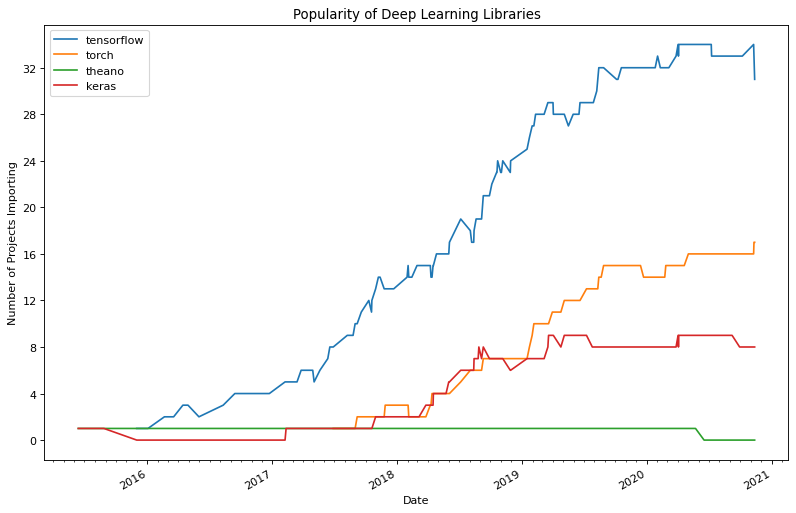

In [7]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots()

ax.plot(tensorflow_counts['date'], tensorflow_counts['count'], label='tensorflow')
ax.plot(torch_counts['date'], torch_counts['count'], label='torch')
ax.plot(theano_counts['date'], theano_counts['count'], label='theano')
ax.plot(keras_counts['date'], keras_counts['count'], label='keras')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Projects Importing')
ax.set_title('Popularity of Deep Learning Libraries')
ax.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
                           
# datemin = datetime.date(ml_repo_import_diffs_timeline['date'].min().year, 1, 1)
# datemax = datetime.date(ml_repo_import_diffs_timeline['date'].max().year + 1, 1, 1)
# ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.show()


## Call Statements

In [48]:
calls.sample(10)
calls[
    (calls['name'].str.startswith('theano.')) &
    ~(calls['name'].str.contains('\(')) & 
    ~(calls['name'].str.contains('\)'))
]

,file,file_in_repo,repo,repo_version,name,parent_function
3242,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.1.4,theano.shared,variable
3284,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.1.4,theano.function,count_params
3383,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.1.4,theano.sandbox.cuda.dnn.dnn_batch_normalization_train,_old_normalize_batch_in_training
3384,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.1.4,theano.tensor.as_tensor_variable,_old_normalize_batch_in_training
3385,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.1.4,theano.tensor.as_tensor_variable,_old_normalize_batch_in_training
...,...,...,...,...,...,...
721158,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.3.0,theano.map,map_fn
721159,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.3.0,theano.foldl,foldl
721161,theano_backend.py,keras/backend/theano_backend.py,keras-team/keras,2.3.0,theano.foldr,foldr
4690364,optimizers.py,elephas/optimizers.py,maxpumperla/elephas,0.2.1,theano.shared,get_gradients


In [80]:
dp_library = 'torch'
call_counts = repo_call_diffs_timeline[
    (repo_call_diffs_timeline['call'].str.startswith(f'{dp_library}.')) & 
    ~(repo_call_diffs_timeline['call'].str.contains('\(')) & 
    ~(repo_call_diffs_timeline['call'].str.contains('\)'))
]
call_counts = call_counts[call_counts['count'] >= 10]


In [81]:
call_counts.sort_values(by=['date'])

,date,call,count
6453214,2019-01-23T00:00:00,torch.cuda.is_available,10
6457043,2019-01-23T00:00:00,torch.from_numpy,10
6491520,2019-01-24T00:00:00,torch.cuda.is_available,10
6495349,2019-01-24T00:00:00,torch.from_numpy,10
6529896,2019-01-27T00:00:00,torch.cuda.is_available,10
...,...,...,...
24402857,2020-11-20T00:00:00,torch.cat,15
24400996,2020-11-20T00:00:00,torch.cuda.is_available,16
24421594,2020-11-20T00:00:00,torch.tensor,12
24406907,2020-11-20T00:00:00,torch.load,17


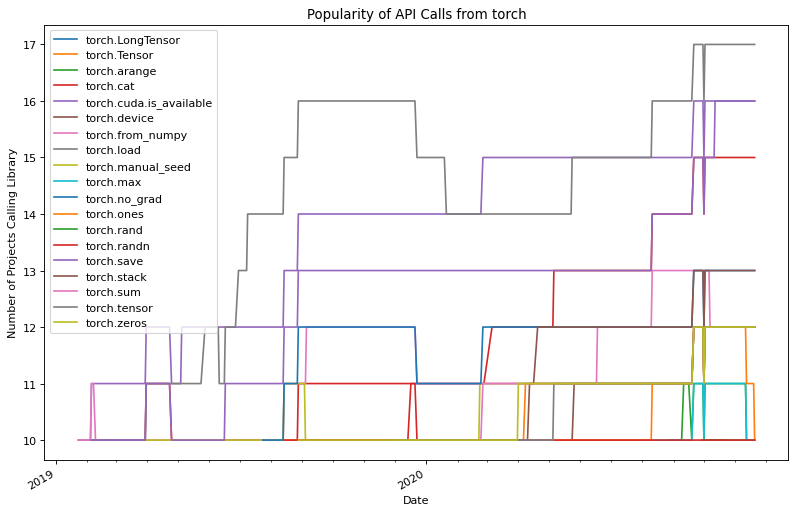

In [82]:

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots()

for label, df in call_counts.groupby(by="call"):
#     df['count'].plot(kind="kde", ax=ax, label=label)
    ax.plot(pd.to_datetime(df['date']), df['count'], label=label)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Projects Calling Library')
ax.set_title(f'Popularity of API Calls from {dp_library}')
ax.legend()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
                           

fig.autofmt_xdate()

plt.show()